In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
  th {font-size: 15px}
  td {font-size: 15px}
</style>

# Outlier Filtering Paradox

Your product manager Tommy got an idea: what if Zalando's website background uses an image of a duck? 

"Only 30% traffic!" After weeks of persuation, his manager yielded. Well, that's good enough. In fact, Octopus already supports unequal weights of assignment traffic. Tommy went ahead and set up a 30/70 experiment. Randomizated sampling works as expected. Two weeks later, the experiment finished. 

Now, join me to take a look at the duck's conversion rate!

## Experiment Data

Let's first take a look at the orders in the control group, who saw a background image of Zalando models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Make a util function for plots
def plot(df, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = np.arange(df.size)
    plt.plot(x, df)
    plt.xlabel("Rank of User")
    plt.ylabel("Number of Orders")
    plt.title(title)
    plt.subplot(122)
    x = np.arange(df.size)
    plt.plot(x, df)
    plt.xlabel("Rank of User")
    plt.ylabel("Number of Orders")
    plt.xlim(df.size*0.88, df.size*1.01)
    plt.title(title + " (Zoom In)")
    plt.show()

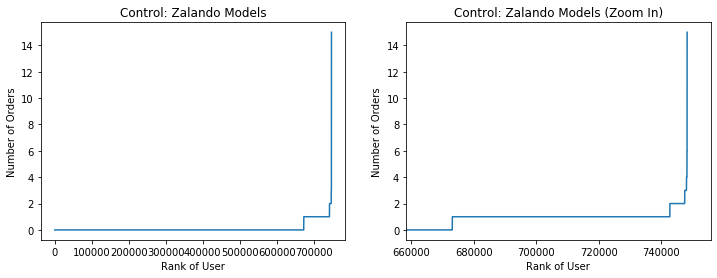

In [3]:
c = pd.read_csv("control_orders.csv", squeeze=True)
plot(c, "Control: Zalando Models")

We observed that number of orders is highly zero-inflated. The majority of users didn't make any order. A small proportion of users made multiple orders during the experiment period. This observation is well aligned with what we know about order data from historical experiments. Perfectly expected data. No surprise here.

Let's now fetch the data for treatment group who saw the image of a duck.

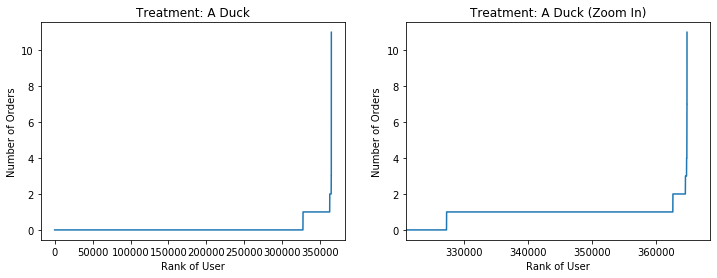

In [4]:
t = pd.read_csv("treatment_orders.csv", squeeze=True)
plot(t, "Treatment: A Duck")

Also zero-inflated. Also expected behavior. 

Keeping in mind that conversion rate is defined as number of orders per user, let's check out the difference of treatment and control then!

In [5]:
def output_uplift(c, t):
    c_cr, t_cr = c.mean(), t.mean()
    print("Uplift of conversion rate: {:+.2f}.".format((t_cr - c_cr) * 100))

In [6]:
output_uplift(c, t)

Uplift of conversion rate: +0.05.


From what we learned so far, a duck image helps Zalando to convert more!

## Outlier Filtering

Right before the duck image is released to the whole population, Tommy's manager invited an Octopus member to double check the analysis. The Octopus member claimed that we need to do outlier filtering in the analysis. 

"You see, these extremely large number of orders may come from administrative accounts or blindly loyal customers. A different background image won't affect their purchases, so we should filter them out." The Octopus member insisted.

Tommy then took the advice and filterd out users who are above 99.9% quantile.

In [7]:
t999 = t.quantile(.999)
c999 = c.quantile(.999)

In [8]:
t_normal = t[t <= t999]
c_normal = c[c <= c999]
output_uplift(c_normal, t_normal)

Uplift of conversion rate: -0.05.


The treatment effect went from +0.05 to -0.05!  
The result changes direction after outlier filtering.

For this to happen, there must be larger numbers of orders from the outlier users in the treatment group. That's why removing them causes the control group start to perform better. With this hypothesis, let's compare the number of orders in the outlier users.

In [9]:
t_outliers = t[t > t999]
c_outliers = c[c > c999]
output_uplift(c_outliers, t_outliers)

Uplift of conversion rate: -136.45.


## What's Going On?!
Heck!? Emm... let's summarize what we got:

| Conversion Rate          | Overall | Normal Users | Outlier Users |
| ---------------          | --------| --------     |  --------     |
| Treatment Effect Uplift  |   +0.05 |        -0.05 |       -136.45 |


So we divided the samples into two subgroups: normal users who are below 99.9% quantile and outlier users who are above 99.9% quantile. Control group shows higher conversion rate in both subgroups; however, the treatment group shows overall higher conversion rate! 

It's worth pointing out that this is not an example of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), which occurs usually when the ratio of sample size in each subgroup are highly different. It's not the case here because we take the same quantile for control and treatment. So the ratio of sample size with and without outlier filtering should be very similar. 

Therefore, in our case of quantiles, we expect that the first number should be between other two!  

----
#### We can prove it mathmatically too

Let $\mu_c$ be the mean of control,   
let $\mu_c^n$ be the mean of normal users in control,    
and $\mu_c^o$ be the mean of outlier users in control.   
The same notation $\mu_t$, $\mu_t^n$ and $\mu_t^o$ apply for treatment.

Further, we use $\Delta$ to denote overall uplift,   
$\Delta^{n}$ to denote the uplift for normal users and   
$\Delta^{o}$ to denote the uplift for outlier users.

Let $p$ be the p-percentile used in outlier filtering, which is 99.9% for us.


Then,

$\displaystyle
\begin{aligned}
          \mu_c &= (1-p) \mu_c^{o} + p \mu_c^{n} \\
          \mu_t &= (1-p) \mu_t^{o} + p \mu_t^{n} 
\end{aligned}
$

By linearity,

$\displaystyle
\begin{aligned}
  \mu_t - \mu_c &= (1-p) (\mu_t^{o} - \mu_c^{o}) + p (\mu_t^{n} - \mu_c^{n}) \\
  \Delta &= (1-p) \Delta^{o} + p \Delta^{n}
\end{aligned}
$

----

Thus, the overall uplift must be between the uplift of outlier users and the uplift of normal users. What is going on?

## Quantile Filtering on Discrete Values

The devil is the discrete nature of number of orders -- they can only be non-negative integers. Multiple users can have the number of order which is at 99.9% quantile. These users cross the threshold, making it impossible to locate the exact position of 99.9% quantile. Let's confirm it by looking at the actual quantile value used in data.

In [10]:
print("Actual quantile used for control: {:.4f}".format(c_normal.size / c.size))
print("Actual quantile used for treatment: {:.4f}".format(t_normal.size / t.size))

Actual quantile used for control: 0.9997
Actual quantile used for treatment: 0.9993


Indeed, there are differences between the intended quantile 0.999 and the actual ones used. The next question is: does this difference really cause the paradox described above? 

Since number of orders is non-negative integer, adding a tiny random noise to the data won't influence the mean value, but the random noise can make the discrete integers into continous values, making it possible to identify the exact position of 99.9% quantile.

In [11]:
def add_jitter(c, t):
    # Add vectors or random noise in the range of -0.005 to 0.005
    c_jitter = np.random.random(len(c)) * 0.01 - 0.005
    t_jitter = np.random.random(len(t)) * 0.01 - 0.005
    return c + c_jitter, t + t_jitter

In [12]:
# Apply the same computation on the noisy data

print("Overall:")
cj, tj = add_jitter(c, t)
output_uplift(cj, tj)

print("Normal users:")
tj999 = tj.quantile(.999)
cj999 = cj.quantile(.999)
tj_normal = tj[tj <= tj999]
cj_normal = cj[cj <= cj999]
output_uplift(cj_normal, tj_normal)

print("Outlier users:")
tj_outliers = tj[tj > tj999]
cj_outliers = cj[cj > cj999]
output_uplift(cj_outliers, tj_outliers)

print("---")
print("Actual quantile used for noisy control: {:.4f}".format(cj_normal.size / cj.size))
print("Actual quantile used for noisy treatment: {:.4f}".format(tj_normal.size / tj.size))

Overall:
Uplift of conversion rate: +0.05.
Normal users:
Uplift of conversion rate: +0.10.
Outlier users:
Uplift of conversion rate: -48.84.
---
Actual quantile used for noisy control: 0.9990
Actual quantile used for noisy treatment: 0.9990


The result makes much more sense after adding random noise to data.
Putting it altogether we have the conversion rate table:
    
| Treatment Effect Uplift  | Overall | Normal Users | Outlier Users | Actual Quantiles (c/t) |
| ---------------          | --------| --------     |  --------     | -------                |
| Original discrete data   |   +0.05 |        -0.05 |       -136.45 | 0.9997 / 0.9993        |
| Data with random jitter  |   +0.05 |        +0.10 |       -48.84  | 0.9990 / 0.9990        |

## Why Small Quantile Difference Leads to Large Bias?

todo

## Warning Message to Octopus

todo

## Next Steps

todo